In [ ]:
import warnings

import bionty as bt
import lamindb as ln
import spatialdata as sd
import spatialdata_plot
import pandas as pd

warnings.filterwarnings("ignore")

# Query and download datasets from Spatialdata-DB

To be able to search for datasets and download them, first we need to specify the data ressource that we want to work with:

In [ ]:
!lamin connect scverse/spatialdata-db

In this notebook you'll find:
- How to use ontologies to search for datasets
- How to download a dataset associated to an Artifact
- Search the ontology hierarchies

### How to use ontologies to search for datasets
 
The following will show an overview of useful query options, but more information and a longer introduction to Lamin's search option can be found on [Lamin query & search](https://docs.lamin.ai/registries).

#### Features linked to a public ontology
If a public ontology exists for feature, we link the value to the ontology term via [`bionty`](https://docs.lamin.ai/bionty).
This currently works for:
- **Assay**
- **Organism**
- **Tissue**
- **DevelopmentalStage**
- **Disease**

**For an overview of all available metadata features, check the `intro.ipynb` notebook.**

Bionty provides registries for all values that are present in the database for a given feature.
Here's an example how to get all available tissues in the database. For simplicity, we only visualize some of the columns:

In [49]:
bt.Tissue.df(limit=None)[['name', 'ontology_id', 'synonyms', 'description']].head(5)

,name,ontology_id,synonyms,description
id,,,,
184,dorsal region element,UBERON:0005174,back organ|dorsal region organ,An Organ Or Element That Part Of The Dorsum Of...
183,dorsum,UBERON:0001137,back of body proper|dorsal part of organism|back,A Major Subdivision Of An Organism That Is The...
182,central nervous system,UBERON:0001017,systema nervosum centrale|CNS,The Central Nervous System Is The Core Nervous...
181,spinal cord,UBERON:0002240,None,Part Of The Central Nervous System Located In ...
180,alimentary part of gastrointestinal system,UBERON:0005409,None,The Part Of The Digestive System That Excludes...


`df()` formats the information in human readable form to get an overview. Bionty also provides `lookup` with autocompletion, which is the fastest way to search for a specific value.

Typing `tissue.` will list the possible values.

In [4]:
tissues = bt.Tissue.lookup(field='name')
organisms = bt.Organism.lookup(field='name')
tissues.bone

Tissue(uid='52I84mkZ', name='bone', created_by_id=8, run_id=279, space_id=1, created_at=2025-03-10 14:48:10 UTC)

These values can then be used to filter for Artifacts that match certain features, e.g. all datasets with `Organism = mouse` and `Tissue = brain`:

In [5]:
query = ln.Artifact.filter(
    organisms=organisms.mouse,
    tissues=tissues.brain,
)

We get an overview of the aritfacts that match the search criteria via `query.df()` with:
- the unique identifier (uid)
- the virtual key, which can be ignored for now
- the description text that was provided by the person that uploaded the dataset
- the type of the dataset - here we'll always have `spatialdata` objects



In [48]:
query.df(include=['otype']).head(5)

,uid,key,description,otype
id,,,,
494,hPDSmcFS5zKswuWh0000,None,Adult Mouse Brain (FFPE) (nan),spatialdata
441,zyFfbyriuoAO4W3i0000,None,"Mouse Brain (FFPE Mouse Brain (Sagittal), Spac...",spatialdata
442,NHGhLJMRmk43kC1Z0000,None,"Mouse Brain (FFPE Mouse Brain (Sagittal), Spac...",spatialdata
443,CFijD3d98yZrbkgP0000,None,Mouse Brain (Fresh Frozen Mouse Brain (Sagitta...,spatialdata
444,LZG1DnEt1p88BxV50000,None,Mouse Brain (Fixed Frozen Mouse Brain (Sagitta...,spatialdata


and can select individual artifact either via list index, e.g. `query[1]`, or using the Artifact uid `ln.Artifact.get('ubllg1iYQBaiDJfW0000')` and display the associated features.

In [ ]:
ln.Artifact.get("zyFfbyriuoAO4W3i0000")

Artifact(uid='hPDSmcFS5zKswuWh0000', is_latest=True, description='Adult Mouse Brain (FFPE) (nan)', suffix='.zarr', otype='spatialdata', size=46932107, hash='vwXVfiX-FDvdcM5P6avToA', n_files=323, space_id=1, storage_id=2, run_id=291, created_by_id=8, created_at=2025-03-12 08:18:36 UTC)

In [ ]:
artifact = query[0]  # == ln.Artifact.get('zyFfbyriuoAO4W3i0000')
artifact

Artifact(uid='zyFfbyriuoAO4W3i0000', is_latest=True, description='Mouse Brain (FFPE Mouse Brain (Sagittal), Space Ranger v2.1.0)', suffix='.zarr', otype='spatialdata', size=109884763, hash='73wdWsHXlWDaOJ5V31XZwg', n_files=451, space_id=1, storage_id=2, run_id=291, created_by_id=8, created_at=2025-03-12 07:00:43 UTC)

In [50]:
artifact.features.get_values()

{'Analysis Steps': 'spaceranger count',
 'Assay': 'Visium Spatial Gene Expression',
 'Biomaterial Type': 'Specimen from Organism',
 'Cells or Nuclei': 'unknown',
 'Chemistry Version': 'Visium CytAssist v2',
 'Dataset Url': 'https://www.10xgenomics.com/datasets/preservation-method-comparison-on-visium-cytassist-ffpe-mouse-brain-sagittal-11-mm-capture-area-2-standard',
 'Development Stage': 'unknown',
 'Disease': 'healthy',
 'Instrument(s)': 'Visium CytAssist',
 'License': 'Creative Commons Attribution 4.0 International',
 'Modality': 'RNA',
 'Organism': 'mouse',
 'Preservation Method': 'FFPE',
 'Product': 'Spatial Gene Expression',
 'Publish Date': '2023-06-08',
 'Replicate': 'FFPE Mouse Brain (Sagittal), Space Ranger v2.1.0',
 'Software': 'Space Ranger v2.1.0',
 'Staining Method': 'H&E',
 'Tissue': 'brain'}

We can now download the dataset that is contained in the selected Artifact with the function `artifact.path.download_to(local_path: str)`.

**Known issues:**
At the moment, the download function does not check whether there's already a dataset stored at the target_path. If downloaded again to the same path, a new `spatialdata` object will be created within the first `zarr` object.

### How to download a dataset associated to an Artifact

In [ ]:
path = './example_dataset_mouse_brain.zarr'
artifact.path.download_to(path)

In [16]:
sdata = sd.read_zarr(
    path
)
sdata

SpatialData object, with associated Zarr store: /ictstr01/home/icb/lea.zimmermann/projects/spatialdata-db/spatialdata-db/docs/notebooks/example_dataset_mouse_brain.zarr
├── Images
│     ├── 'CytAssist_FFPE_Sagittal_Mouse_Brain_full_image': DataTree[cyx] (3, 2000, 1865), (3, 1000, 932), (3, 500, 466), (3, 250, 233), (3, 125, 116)
│     ├── 'CytAssist_FFPE_Sagittal_Mouse_Brain_hires_image': DataArray[cyx] (3, 2000, 1865)
│     └── 'CytAssist_FFPE_Sagittal_Mouse_Brain_lowres_image': DataArray[cyx] (3, 600, 560)
├── Shapes
│     └── 'CytAssist_FFPE_Sagittal_Mouse_Brain': GeoDataFrame shape: (8470, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (8470, 19465)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Sagittal_Mouse_Brain_hires_image (Images), CytAssist_FFPE_Sagittal_Mouse_Brain (Shapes)
    ▸ 'downscaled_lowres', with elements:
        CytAssist_FFPE_Sagittal_Mouse_Brain_lowres_image (Images), CytAssist_FFPE_Sagittal_Mouse_Brain (Shapes)
 

The sample-specific metadata can then be accessed in the `spatialdata.attrs` slot:

In [19]:
sdata.attrs['sample']

{'Analysis Steps': 'spaceranger count',
 'Assay': 'Visium',
 'Biomaterial Type': 'Specimen from Organism',
 'Cells or Nuclei': 'unknown',
 'Chemistry Version': 'Visium CytAssist v2',
 'Collection Description': 'Preservation Method Comparison on Visium CytAssist 11 mm Capture Area',
 'Dataset Url': 'https://www.10xgenomics.com/datasets/preservation-method-comparison-on-visium-cytassist-ffpe-mouse-brain-sagittal-11-mm-capture-area-2-standard',
 'Description': 'Mouse Brain',
 'Development Stage': 'unknown',
 'Disease': 'healthy',
 'Disease Details': '',
 'Donor Count': 'unknown',
 'Instrument(s)': 'Visium CytAssist',
 'License': 'Creative Commons Attribution 4.0 International',
 'Modality': 'RNA',
 'Organism': 'Mouse',
 'Panel': nan,
 'Preservation Method': 'FFPE',
 'Product': 'Spatial Gene Expression',
 'Publish Date': '2023-06-08',
 'Replicate': 'FFPE Mouse Brain (Sagittal), Space Ranger v2.1.0',
 'Software': 'Space Ranger v2.1.0',
 'Staining Method': 'H&E',
 'Tissue': 'brain'}

Now for a quick first look into the data sample:

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.82575756..1.0].


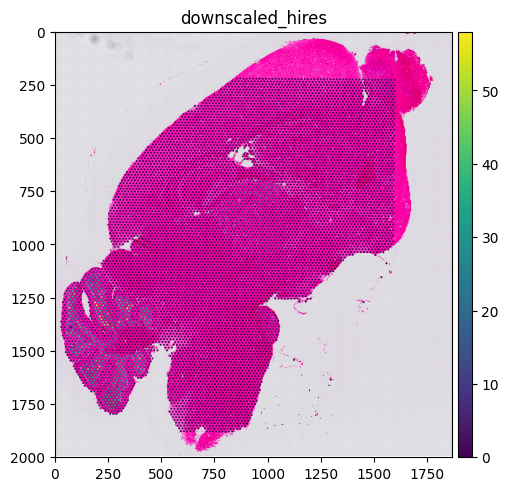

In [29]:
(
    sdata
    .pl.render_images(elements="CytAssist_FFPE_Sagittal_Mouse_Brain_hires_image")
    .pl.render_shapes(elements="CytAssist_FFPE_Sagittal_Mouse_Brain", color="ENSMUSG00000032368")
    .pl.show("downscaled_hires")
)

### Search the ontology hierarchies

If you're not looking for a specific disease, but rather a range of diseases such as all `leukemia` subtypes, you can use the hierarchy of the ontologies to retrieve all children of one value:

In [47]:
diseases = bt.Disease.lookup(field='name')

leukemia = diseases.leukemia
leukemia_subtypes = leukemia.query_children()
leukemia_subtypes.df()

,uid,name,ontology_id,abbr,synonyms,description,space_id,source_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,
62,3tVTgJ1k,lymphoid leukemia,MONDO:0005402,None,subacute lymphoid leukaemia|lymphogenous leuke...,A Malignant Lymphocytic Neoplasm Of B-Cell Or ...,1,83,279,2025-03-10 15:34:35.798085+00:00,8,None,1
53,7OtSpdnC,acute lymphoblastic leukemia,MONDO:0004967,None,precursor cell lymphoblastic leukemia|acute ly...,"Leukemia With An Acute Onset, Characterized By...",1,83,279,2025-03-10 15:34:34.883025+00:00,8,None,1
64,7EIZsogb,acute leukemia,MONDO:0010643,None,acute leukemia (disease)|acute leukemia|acute ...,A Clonal (Malignant) Hematopoietic Disorder Wi...,1,83,279,2025-03-10 15:34:35.798085+00:00,8,None,1
